C:\Users\HP\AppData\Local\Temp\ipykernel_2384\1369246749.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.empty((train_len,), dtype=np.int)


Images successfully imported. Total images: 87000
X_train shape :  (87000, 64, 64, 3)
y_train shape :  (87000,)
Unique image shapes in X_train: {(64, 64, 3)}


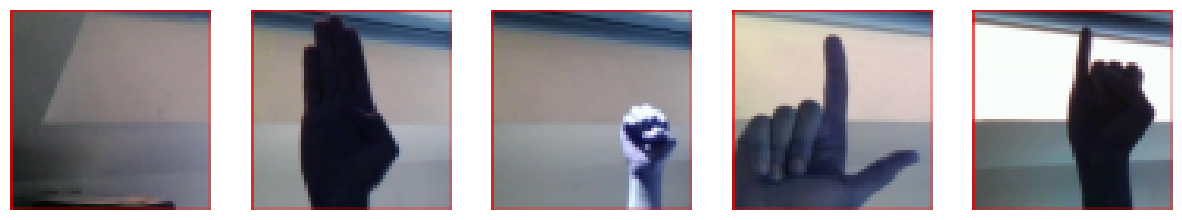

Copies of X_train and y_train have been created.
Shape of X_train: (60900, 64, 64, 3)
Shape of y_train: (60900,)

Shape of X_test: (26100, 64, 64, 3)
Shape of y_test: (26100,)

Shape of X_test: (60900, 29)
Shape of y_test: (26100, 29)

Shape of X_data: (87000, 64, 64, 3)
Shape of y_data: (87000,)


In [3]:
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, concatenate

%run data_prep.ipynb

In [5]:
# Initial model
model = Sequential(name="initial_model")
model.add(Conv2D(32, (5, 5), input_shape=(image_size, image_size, 3), name='initial_conv1'))
model.add(Activation('relu', name='initial_activation1'))
model.add(MaxPooling2D((2, 2), name='initial_maxpool1'))

model.add(Conv2D(64, (3, 3), name='initial_conv2'))
model.add(Activation('relu', name='initial_activation2'))
model.add(MaxPooling2D((2, 2), name='initial_maxpool2'))

model.add(Conv2D(64, (3, 3), name='initial_conv3'))
model.add(Activation('relu', name='initial_activation3'))
model.add(MaxPooling2D((2, 2), name='initial_maxpool3'))

In [6]:
# Pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [7]:
for layer in vgg16.layers:
    layer.trainable = False

In [8]:
vgg_output = vgg16.output

In [9]:
vgg_output = Flatten()(vgg_output)

In [10]:
from tensorflow.keras.layers import Reshape
reshaped_output = Reshape(target_shape=(-1,))(model.output)

In [11]:
combined_output = concatenate([reshaped_output, vgg_output])

In [12]:
combined_output = Dense(64, activation='relu')(combined_output)
combined_output = Dense(num_classes, activation='softmax')(combined_output)

In [13]:
final_model = Model(inputs=[model.input, vgg16.input], outputs=combined_output)

final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

In [14]:
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [15]:
history = final_model.fit([X_train, X_train], y_cat_train, epochs=50, batch_size=64, verbose=2,
                          validation_data=([X_test, X_test], y_cat_test), callbacks=[early_stop])

Epoch 1/50
952/952 - 2167s - loss: 0.8201 - accuracy: 0.7897 - val_loss: 0.1904 - val_accuracy: 0.9486 - 2167s/epoch - 2s/step
Epoch 2/50
952/952 - 2573s - loss: 0.0846 - accuracy: 0.9796 - val_loss: 0.0543 - val_accuracy: 0.9874 - 2573s/epoch - 3s/step
Epoch 3/50
952/952 - 2785s - loss: 0.0359 - accuracy: 0.9914 - val_loss: 0.0355 - val_accuracy: 0.9906 - 2785s/epoch - 3s/step
Epoch 4/50
952/952 - 2464s - loss: 0.0240 - accuracy: 0.9944 - val_loss: 0.0466 - val_accuracy: 0.9860 - 2464s/epoch - 3s/step
Epoch 5/50
952/952 - 2093s - loss: 0.0124 - accuracy: 0.9974 - val_loss: 0.0103 - val_accuracy: 0.9969 - 2093s/epoch - 2s/step
Epoch 6/50
952/952 - 2106s - loss: 0.0211 - accuracy: 0.9943 - val_loss: 0.0103 - val_accuracy: 0.9975 - 2106s/epoch - 2s/step
Epoch 7/50
952/952 - 2090s - loss: 0.0077 - accuracy: 0.9985 - val_loss: 0.0274 - val_accuracy: 0.9925 - 2090s/epoch - 2s/step


In [16]:
final_model.evaluate([X_test, X_test], y_cat_test, verbose=0)

[0.027423707768321037, 0.9925287365913391]

In [17]:
final_model.save('model-with-transfer-learning.h5')